In [4]:
import pandas as pd
import os
import sys
from collections import defaultdict
from pathlib import Path
import numpy as np
import json
import ipdb
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

hoops_dir = Path("/Users/danielfriedman/Desktop/hoops")
data_dir = hoops_dir / "data"
sys.path.append(hoops_dir.as_posix())

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 30)

from pipeline import team_metadata, score_by_score, rank, playstats, merge

In [5]:
def plot(w=9, h=6):
    return plt.subplots(figsize=(w, h))

In [6]:
first_season = "2014-15"
last_season = "2021-22"
importlib.reload(merge)
m = merge.merge(first_season, last_season)


#### Empirical Means

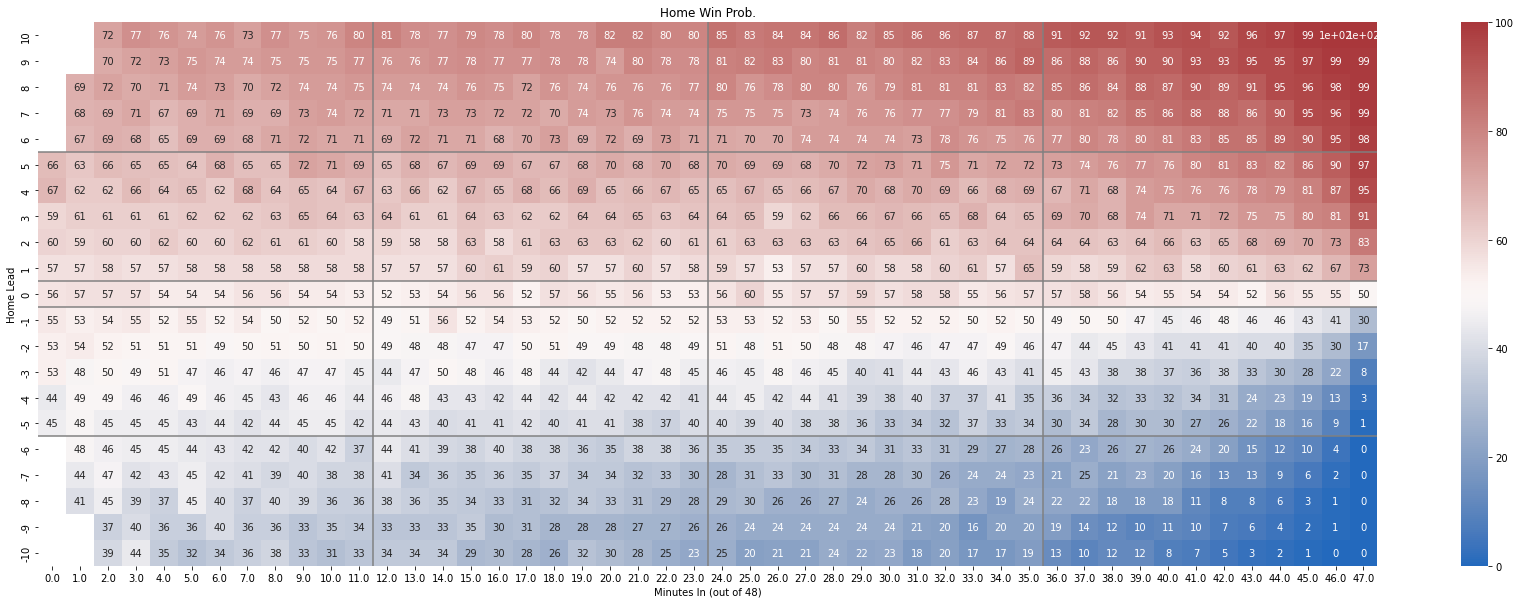

In [7]:
time_mod = 1
score_mod = 1

x = m.drop_duplicates(subset=['game_id', 'mins', 'home_lead']).groupby(["mins", "home_lead"]).agg({'home_win': ['count', 'mean']})['home_win'].reset_index().rename(columns={'mean':'win_pct'})
x['win_pct'] = (x['win_pct'] * 100).astype(int)
x = x.loc[x['count'] >= 50]
x = x.pivot(index='home_lead', columns='mins', values='win_pct')
x.index = np.array(list(x.index)) * score_mod
x.columns = np.array(list(x.columns)) * time_mod

fig, ax = plt.subplots(figsize=(30, 10))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
ax.axhline(10, color='gray')
ax.axhline(11, color='gray')
ax.axhline(5, color='gray')
ax.axhline(16, color='gray')
sns.heatmap(x.loc[10:-10:-1, 0:47], annot=True, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Home Win Prob.");



___

# FFNN

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Activation
from sklearn.preprocessing import StandardScaler


In [48]:
def score_model(m, features, layer_sizes, lr=1e-6, batch_size=32, cutoff="2021-09-01"):
    
    ## Get data
    m_ = m.loc[m['time'] < 48].dropna(axis=0).reset_index(drop=True).copy(deep=True)
    m_['time_left'] = np.log(48-m_['time'])
    m_['home_lead_pml'] = m_['home_lead'] / np.sqrt(48-m_['time'])
    X_train = m_.loc[m_['date'] <= cutoff, features].to_numpy()
    X_test = m_.loc[m_['date'] > cutoff, features].to_numpy()
    y_train = m_.loc[m_['date'] <= cutoff, 'home_win'].astype(int).to_numpy()
    y_test = m_.loc[m_['date'] > cutoff, 'home_win'].astype(int).to_numpy()
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)
    
    ## Model
    # Construct
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_train_scaled.shape[1],)))
    for layer_size in layer_sizes:
        initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)
        model.add(layers.Dense(layer_size, activation="relu", kernel_initializer=initializer))    
    model.add(layers.Dense(1, activation='sigmoid'))
    print(model.summary())
    # Compile
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
    # Fit
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(
        X_train_scaled,
        y_train,
        batch_size=batch_size,
        epochs=500,
        validation_data=(X_test_scaled, y_test),
        callbacks=[callback],
        verbose=2
    )
    # Score
    score = history.history['val_loss'][-1]
    
    ## Write out
    name = "_".join([str(size) for size in layer_sizes]) + "|" + "_".join(features)
    details = {'features': features, 'layer_sizes': layer_sizes, 'score': score}
    with open(f"model/scores/{name}.json", 'w') as f:
        json.dump(details, f)
        
    ## Return model
    return model, history, ss


In [49]:
## Get features
features = ['home_lead', 'time_left', 'ppm', 'home_ranking', 'vis_ranking', 'home_lead_pml']
layer_sizes = [16, 32, 8]
lr = 1e-6
batch_size = 64
cutoff = "2021-09-01"
model, history, ss = score_model(m, features, layer_sizes, lr, batch_size, cutoff)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                112       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 929
Trainable params: 929
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
14416/14416 - 6s - loss: 0.6923 - acc: 0.5702 - val_loss: 0.6915 - val_acc: 0.5441
Epoch 2/500
14416/14416 - 6s - loss: 0.6885 - acc: 0.6023 - val_loss: 0.6863 - val_acc: 0.6451
Epoch 3/500
14416/14416 - 6s - loss: 0.6805 - acc: 0.7250 -

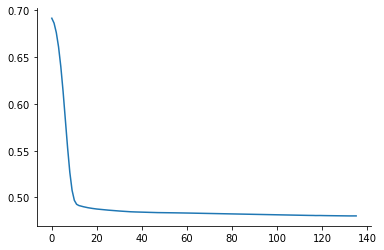

In [50]:
i=0
sns.lineplot(x=np.arange(len(history.history['val_loss'][-i:])), y=history.history['val_loss'][-i:])
sns.despine()

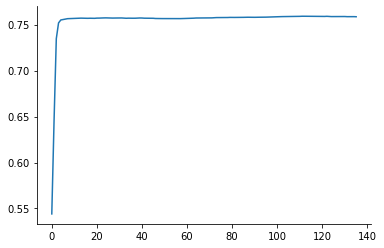

In [51]:
sns.lineplot(x=np.arange(len(history.history['val_acc'])), y=history.history['val_acc'])
sns.despine()

In [52]:
def get_win_probs_by_game_state(model, features, m, ss, home_ranking=0, vis_ranking=0, mins=np.arange(0, 48), home_leads=np.arange(-10, 11), mean_replacers=None):
    m_ = m.loc[m['time'] < 48].dropna(axis=0).reset_index(drop=True).copy(deep=True)
    n_combos = len(mins)*len(home_leads)
    mean_replacers = mean_replacers if mean_replacers is not None else dict()
    dummy_features = [f for f in features if f in m.columns]
    dummy_row = pd.DataFrame(m[dummy_features].mean()).T
    for feature, value in mean_replacers.items():
        dummy_row.loc[0, feature] = value
    dummy_data = pd.concat([dummy_row]*n_combos).reset_index(drop=True)
    time = np.tile(mins, len(home_leads))
    dummy_data['time_left'] = np.log(48-time)
    dummy_data['home_lead'] = np.repeat(home_leads, len(mins))
    dummy_data['home_lead_pml'] = dummy_data['home_lead']/np.sqrt(48-time)
    dummy_data['home_ranking'] = home_ranking
    dummy_data['vis_ranking'] = vis_ranking
    dummy_data_scaled = ss.transform(dummy_data[features].to_numpy())
    dummy_data['yhat'] = model.predict(dummy_data_scaled)[:,0]
    dummy_data['time'] = time
    panel = dummy_data.pivot(index='home_lead', columns='time', values='yhat')
    return panel


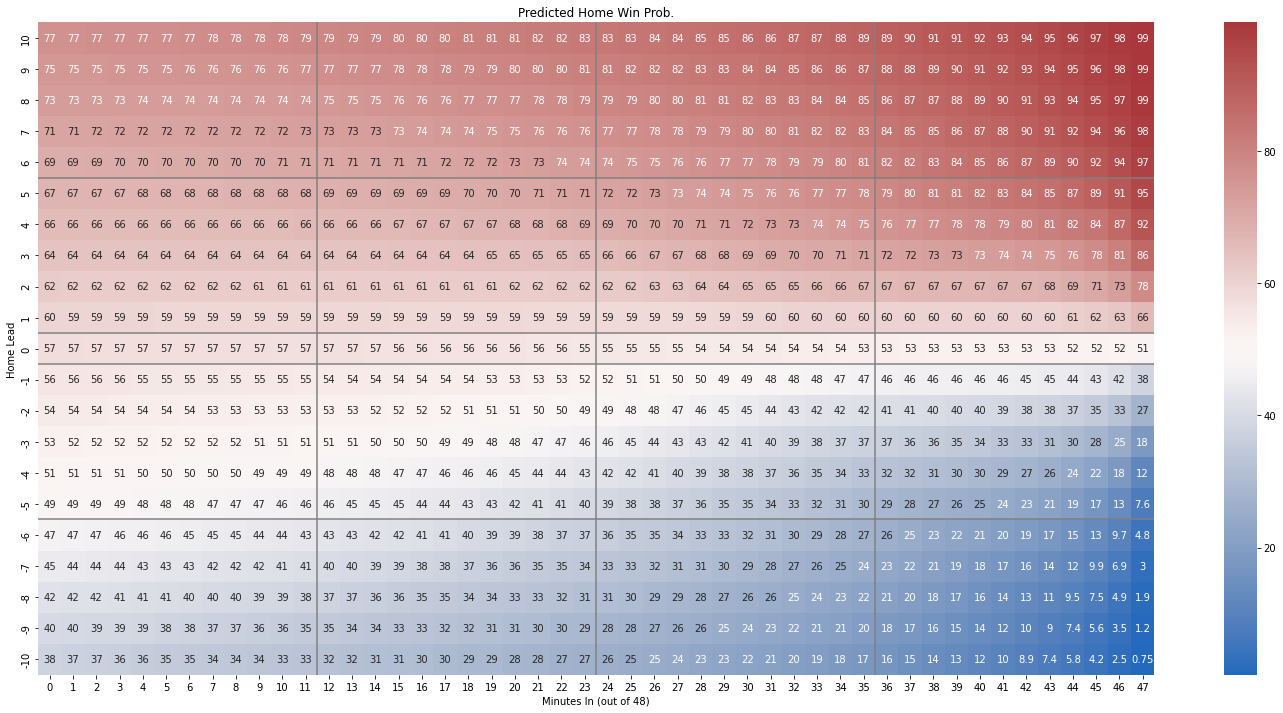

In [53]:
# Get win probs
panel_even = get_win_probs_by_game_state(model, features, m, ss)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_even[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_even[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


<AxesSubplot:xlabel='home_lead'>

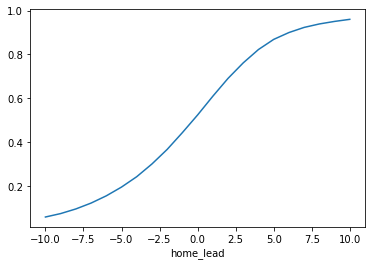

In [54]:
sns.lineplot(x=panel_even[44].index, y=panel_even[44].values)

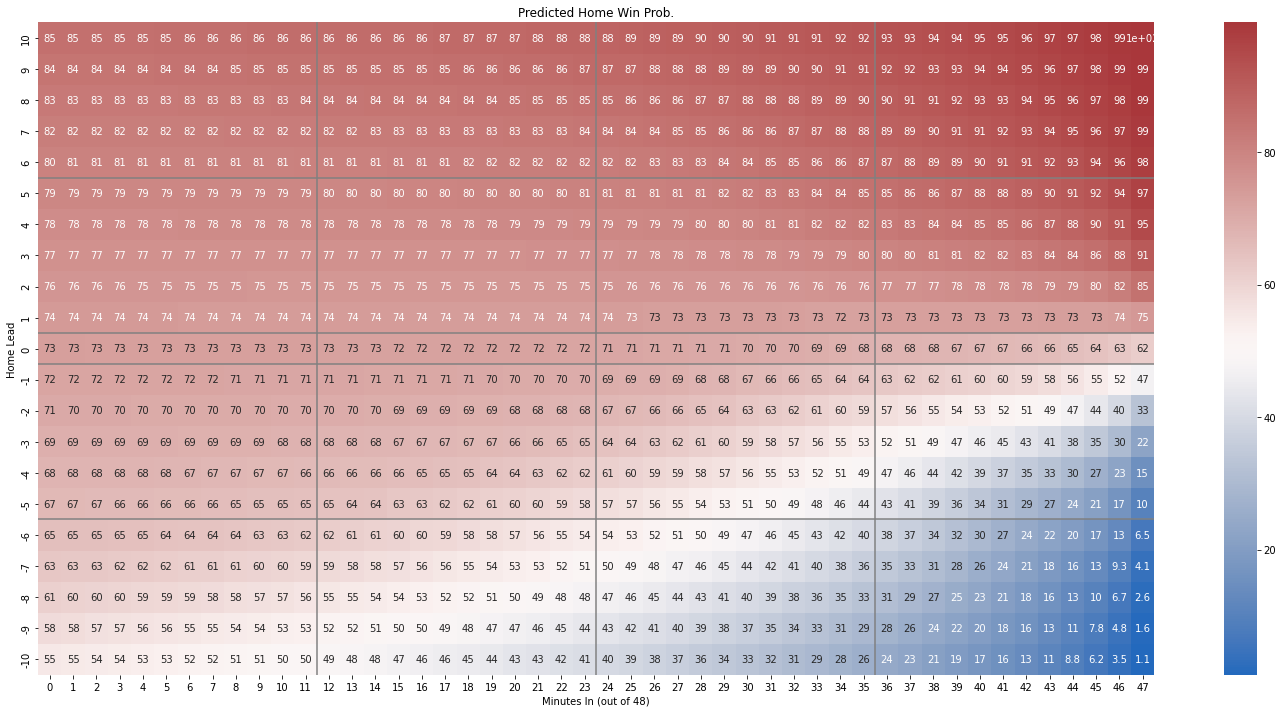

In [55]:
# Get win probs
panel_home_fav = get_win_probs_by_game_state(model, features, m, ss, home_ranking=.5, vis_ranking=-.5)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_home_fav[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_home_fav[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


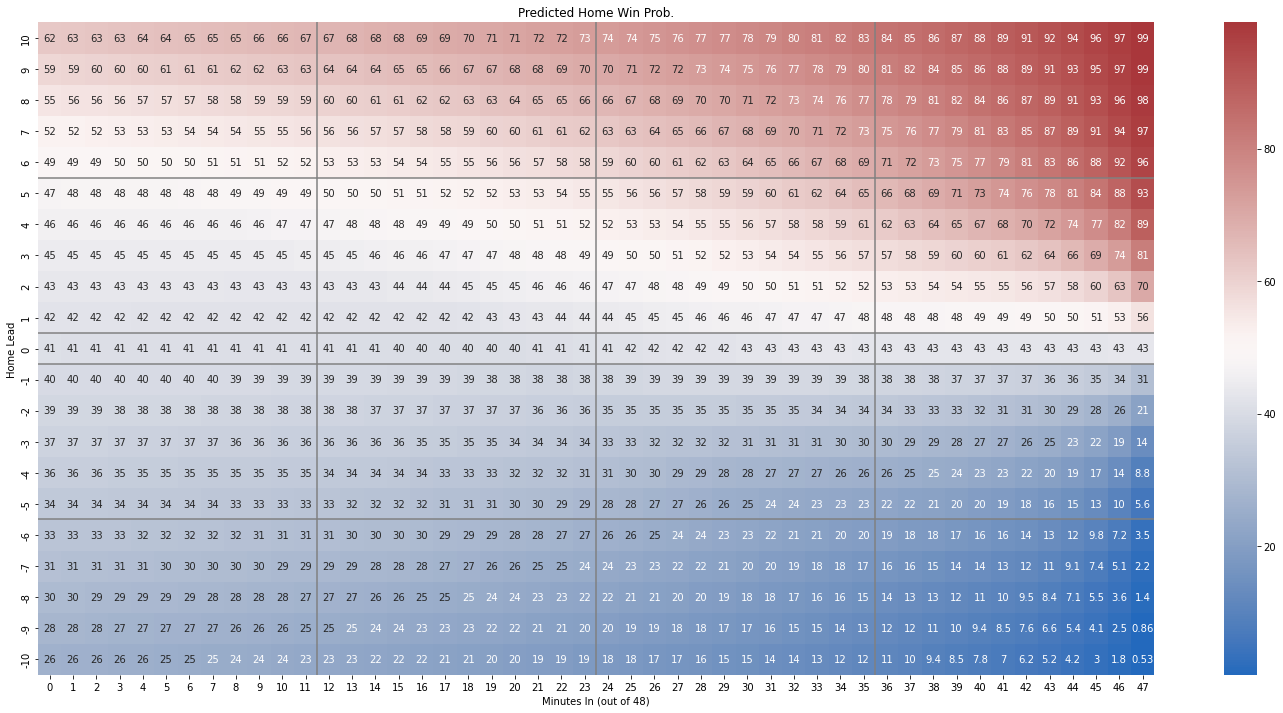

In [56]:
# Get win probs
panel_vis_fav = get_win_probs_by_game_state(model, features, m, ss, home_ranking=-.5, vis_ranking=.5)

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_vis_fav[::-1]*100, annot=True, cmap="vlag")
else:
    sns.heatmap(panel_vis_fav[::-1]*100, annot=False, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


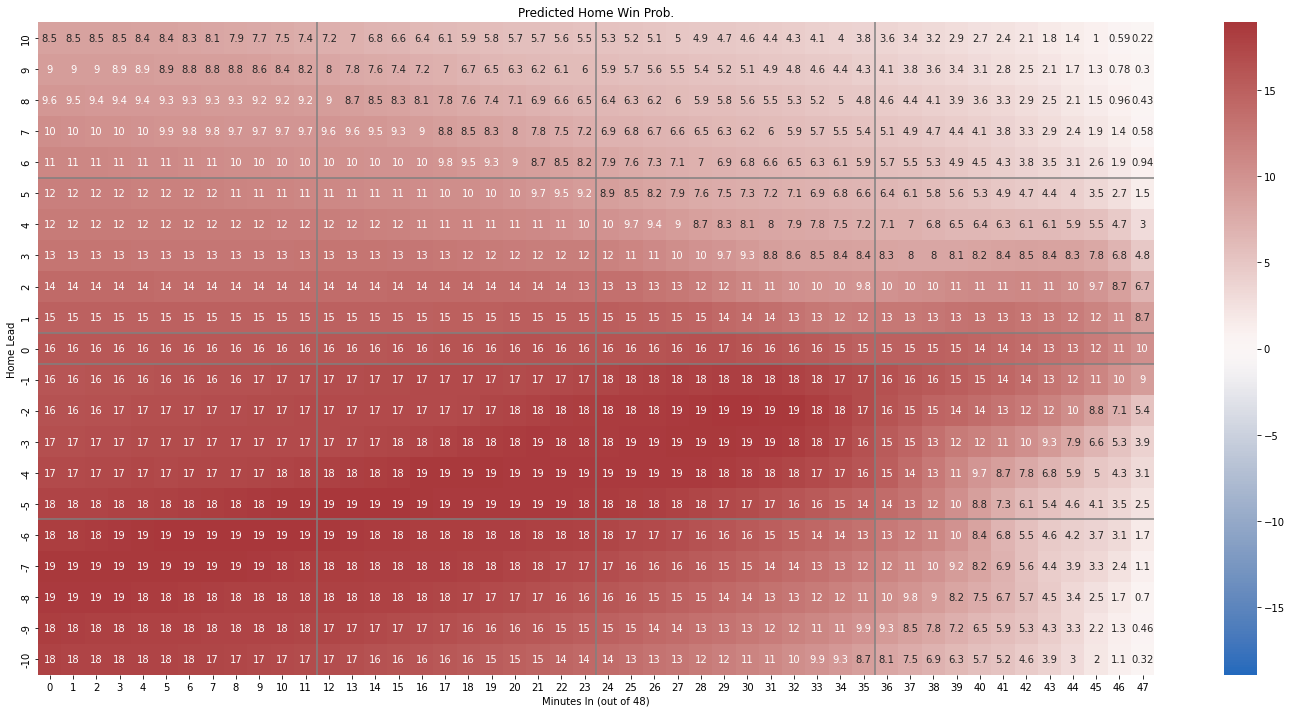

In [57]:
# Plot
fig, ax = plt.subplots(figsize=(25, 12))
annot = False
annot = True
panel_diff = (panel_home_fav[::-1] - panel_even[::-1])*100
vmax = max(-panel_diff.min().min(), panel_diff.max().max())
if annot:
    ax.axvline(12, color='gray')
    ax.axvline(24, color='gray')
    ax.axvline(36, color='gray')
    ax.axhline(10, color='gray')
    ax.axhline(11, color='gray')
    ax.axhline(5, color='gray')
    ax.axhline(16, color='gray')
    sns.heatmap(panel_diff, annot=True, cmap="vlag", vmin=-vmax, vmax=vmax)
else:
    sns.heatmap(panel_diff, annot=False, cmap="vlag", vmin=-vmax, vmax=vmax)
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");


____

In [765]:
sbs = pd.read_csv("data/score_by_score/2021-22.csv")
sbs.loc[sbs['date'] == "2022-03-03"].sample(5)

,game_id,date,home,vis,time,home_score,vis_score,home_win
89759,22100942,2022-03-03,TOR,DET,38.82,85,92,False
89717,22100942,2022-03-03,TOR,DET,22.08,52,53,False
70831,22100710,2022-03-03,ATL,CHI,26.95,67,68,True
89799,22100943,2022-03-03,DAL,GSW,4.57,16,9,True
101481,22100944,2022-03-03,SAS,SAC,13.72,30,34,False


In [786]:
game_sbs = sbs.loc[sbs['game_id'] == 22100943]
game_sbs

,game_id,date,home,vis,time,home_score,vis_score,home_win
89785,22100943,2022-03-03,DAL,GSW,0.00,0,0,True
89786,22100943,2022-03-03,DAL,GSW,0.38,2,0,True
89787,22100943,2022-03-03,DAL,GSW,0.70,2,2,True
89788,22100943,2022-03-03,DAL,GSW,0.97,3,2,True
89789,22100943,2022-03-03,DAL,GSW,0.97,4,2,True
...,...,...,...,...,...,...,...,...
89895,22100943,2022-03-03,DAL,GSW,45.48,115,111,True
89896,22100943,2022-03-03,DAL,GSW,45.73,118,111,True
89897,22100943,2022-03-03,DAL,GSW,46.02,118,113,True
89898,22100943,2022-03-03,DAL,GSW,47.07,120,113,True


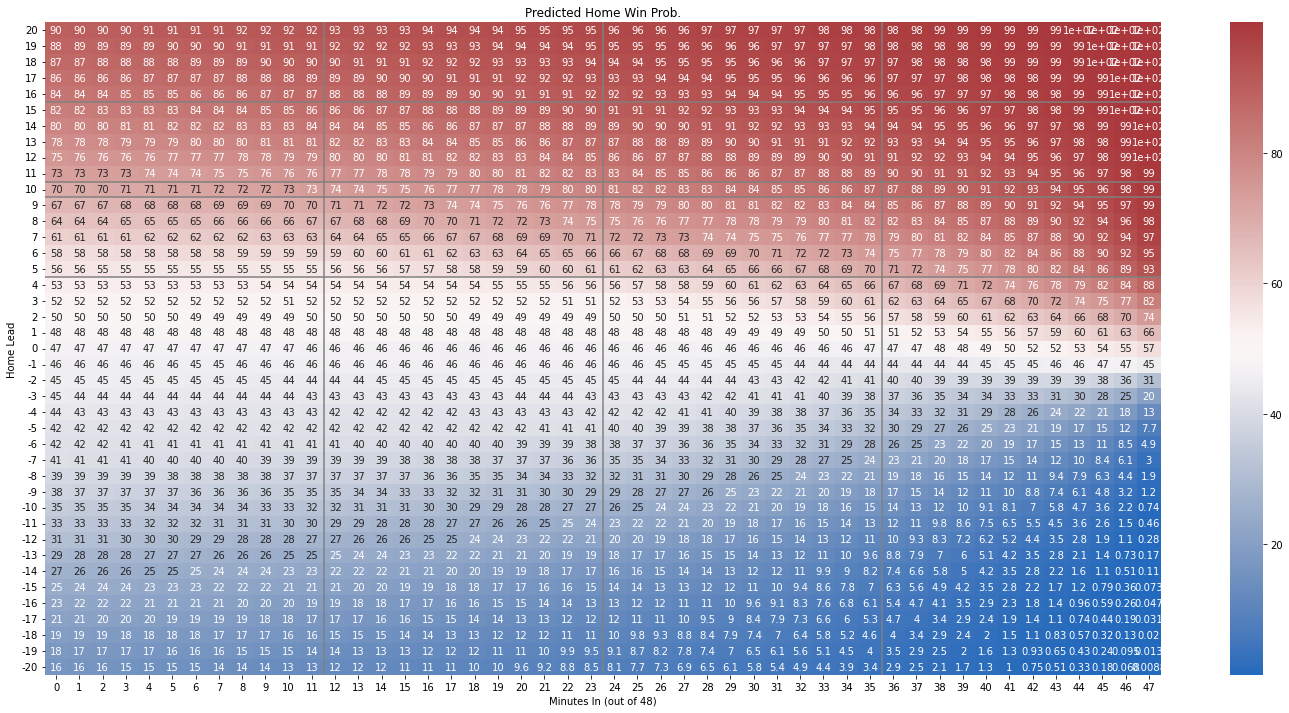

In [969]:
home = game_sbs.iloc[-1]['home']
vis = game_sbs.iloc[-1]['vis']
home_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[home]
vis_ranking = rbd.sort_values("date").groupby("team")['ranking'].last()[vis]
panel = get_win_probs_by_game_state(model, features, m_, ss, home_ranking=home_ranking, vis_ranking=vis_ranking, home_leads=np.arange(-20, 21))

# Plot
fig, ax = plt.subplots(figsize=(25, 12))
ax.axvline(12, color='gray')
ax.axvline(24, color='gray')
ax.axvline(36, color='gray')
ax.axhline(10, color='gray')
ax.axhline(11, color='gray')
ax.axhline(5, color='gray')
ax.axhline(16, color='gray')
sns.heatmap(panel[::-1]*100, annot=True, cmap="vlag")
ax.set(ylabel="Home Lead", xlabel="Minutes In (out of 48)", title="Predicted Home Win Prob.");

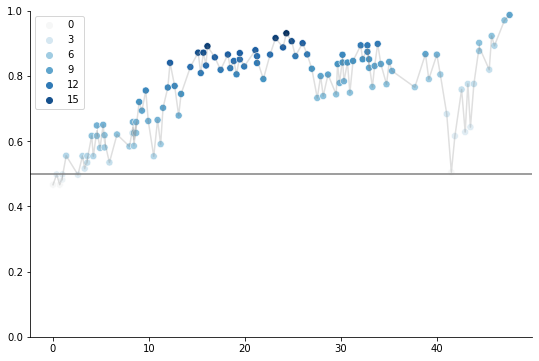

In [970]:
probs = list()
home_leads = list()
time = list()
for _, row in game_sbs.iterrows():
    probs.append(panel.loc[row['home_score']-row['vis_score'], np.floor(row['time'])])
    home_leads.append(row['home_score']-row['vis_score'])
    time.append(row['time'])
probs = [prob for prob in probs]

fig, ax = plt.subplots(figsize=(9, 6))
max_lead = max(-min(home_leads), max(home_leads))
sns.scatterplot(x=time, y=probs, hue=home_leads, palette="RdBu", hue_norm=(-max_lead, max_lead), s=50)
sns.lineplot(x=time, y=probs, color="gray", alpha=0.25) 
ax.axhline(0.5, color='gray')
ax.set_ylim(0, 1)
# ax.grid()
sns.despine()

